# Frozen Lake: Reinforcement Learning

In reinforcement learning, an agent is acting in an environment, and learning by trial-and-error to optimize its performance in order to gain maximal cumulative reward. The model of the environment can be formalized by a Markov Decision Process (MDP), from which the optimal policy can be derived applying dynamic programming algorithms. If the MDP is not known, however, the agent has to find it out by interacting with the environment. In a naive learning strategy, the agent runs many episodes while taking samples to build the MDP. After running these episodes, the empirical MDP is used to approximate the optimal policy applying dynamic programming methods.

This approach works fine for small problems, but is not efficient when the number of states and actions are large. The reinforcement learning algorithms illustrated in this notebook overcome this problem by calculating the value functions after each step or a number of steps, or after each episode. The newly obtained value functions are used then to update the policy following a so called epsilon-greedy strategy. In this way, these methods combine a policy evaluation step, in which the value functions are updated, with a policy improvement step. This procedure of iterative policy evaluation and improvement is the same as in the Policy Iteration algorithm used to solve planning problems. In reinforcement learning problems, however, the MDP is not known.

Therefore the agent has to expore the environment and collect samples in the same way it does following a naive learning strategy, although collecting samples is done more efficiently by updating the policy. However, exploiting the agent's learning experience fully by improving the policy greedily is not an effective strategy either, as it risks to left some part of the environment unexplored. Epsilon-greedy means that there is always a small probability, epsilon, of chosing a non-optimal action so the environment is still being explored by the agent. The learning algorithms discussed here decrease the epsilon probability with the number of episodes run by the agent, and eventually follow an optimal policy as epsilon becomes neglectably small.

In this notebook, four reinforcement learning algorithms are illustrated: Q-Learning, N-Step Q-Learning, Monte Carlo, and Value Iteration. The first three algorithms are model free, which means they don't even need an empirical MDP. They use the sampled rewards to approximate the action-value function Q directly. Q-Learning updates the action-value function after each step the agent takes, N-Step Q-Learning does it every N steps, and Monte Carlo after each episode. Value Iteration uses the collected samples to build an empirical MDP from which the state-value function V is updated after each step applying dynamic programming. This algorithm is similar to the Value Iteration method to solve a given MDP in planning problems, although it is not entirely the same as it applies a slightly different Bellman equation and has an explicit policy improvement step.

The objective of this notebook is to illustrate these four reinforcement learning algorithms by applying them to the deterministic and stochastic Frozen Lake environment. The hyperparameters with which the agent's learning process can be finetuned are not discussed here in detail, nor are they being optimized. This finetuning is the scope of the next notebook.

## Import module ReinforcementLearning 

The reinforcement learning strategies Q-Learning, N-Step Q-Learning, Monte Carlo, and Value Iteration are implemented in the "ReinforcementLearning" module. Importing this module also imports packages "numpy" as "np" and "matplotlib.pyplot" as "plt". Matplotlib is set to the interactive "notebook" mode:

In [1]:
from ReinforcementLearning import *
%matplotlib notebook

The four learning strategies are implemted as separate classes which all inherits from the abstract superclass "LearningStrategy". The latter is a subclass of class "NaiveStrategy", which imlements the naive learning strategy. The four classes are "QLearning", "NStepQLearning", "MonteCarlo", "ValueIteration". In fact, class "MonteCarlo" is a subclass of class "QLearning", and class "NStepQLearning" inherits from class "MonteCarlo". 

Using these classes to solve reinforcement learning problems is straightforward. First an environment is created, which is a deterministic or stochastic "FrozenLake" object in the following examples. Then a "LearningStrategy" object is created implementing the specific algorithm. The constructor requires the number of episodes and the initial policy as input. It also accepts some required and some optional hyperparameters; some of them are common to all strategies, some of them specific to one strategy. All of these input arguments are assigned to attributes with the same name and can be modified after the object was created. Finally, an agent is created which aggregates the environment and the learning strategy objects. Calling the agent's "learn" method solves the learning problem applying the given algorithm.

## Deterministic case 

First, the four learning strategies are illustrated using an agent in the non-slippery Frozen Lake environment:

In [2]:
env = FrozenLake.make(is_slippery=False)

All strategies have the following hyperparameters in common:

In [3]:
num_of_episodes = 500  # number of episodes, required input argument
decay_rate = 0.01  # decay rate defining the epsilon-greedy policy, required input argument
epsilon_min = 0.01  # minimum value for epsilon, optional argument, default value is 0.01
epsilon_max = 1.0  # maximum value for epsilon, optional argument, default value is 1.0
gamma = 0.9  # discount factor, optional argument, default value is 1.0

Discount factor "gamma" is set to 0.9 to obtain the optimal policy showing the shortest path. 

The initial policy is also a required input argument for each strategy, and must be a "Policy" object. Because this object is updated during the agent's learning process, it is recommended to instantiate a new "Policy" object each time a new "LearningStrategy" object is created. Because the policy selects actions randomly, it is interesting the set its random seed in order to reproduce results:

In [4]:
seed = 2020  # random seed for policy

### Exact solution

First the solution is calculated using Frozen Lake's exact MDP and applying the Value Iteration algorithm for planning. In this way, the solutions obtained by the learning algorithms can be verified:  

<IPython.core.display.Javascript object>


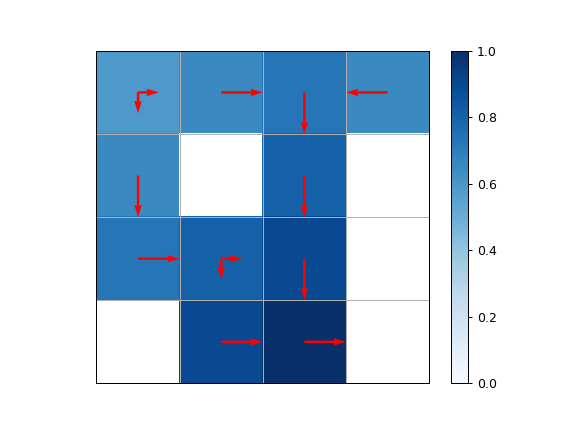

In [5]:
mdp = GymMDP(env, gamma=gamma)
policy_opt, v_opt, q_opt = mdp.value_iteration(outer=1000)
env.plot(values=v_opt, policy=policy_opt)

### Q-Learning 

The Q-Learning algorithm has one specific hyperparameter, the learning rate, which is mostly denoted by the greek letter alpha. This hyperparameter is a required input argument. For deterministic cases, it is set to 1.0. As it is also used by the Monte Carlo and the N-Step Q-Learning methods, it is assigned here once for the three methods: 

In [6]:
learning_rate = 1.0

Now all hyperparameters are defined, a "QLearning" object is created. As explained above, the required "Policy" object holding the initial policy also needs to be created. A uniform random policy is defined: 

In [7]:
policy = UniformRandomPolicy(env)

strategy = QLearning(num_of_episodes=num_of_episodes,
                     policy=policy, 
                     learning_rate=learning_rate, 
                     gamma=gamma,
                     decay_rate=decay_rate,
                     epsilon_min=epsilon_min,
                     epsilon_max=epsilon_max)

Then an "Agent" object is created that aggregates the environment and strategy objects: 

In [8]:
agent = Agent(env, strategy)

Finally the "learn" method of the "Agent" object is called. Before doing that, the random seed for the policy is set: 

<IPython.core.display.Javascript object>


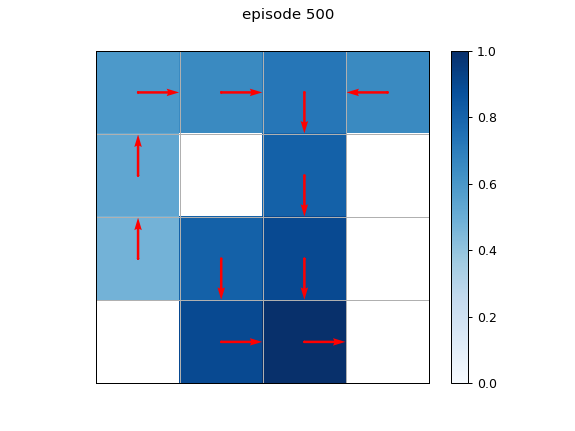

In [9]:
policy.seed(seed)
agent.learn(plot_frequency=50)

The resulting policy indeed follows one of the possible shortest paths from the starting position to the final goal. The Q-values determined for the cells not belonging to this shortest path are not so reliable, because the agent did not visit them frequently, which can be confirmed by checking the frequencies:

In [14]:
for state in [ 0,  1,  2,  3, 
               4,      6,
               8,  9, 10,
                  13, 14,    ]:
    print(str(state) + " has " + str(np.sum(strategy.mdp.Nsa[state, :])) + " visits")

0 has 797 visits
1 has 536 visits
2 has 477 visits
3 has 60 visits
4 has 164 visits
6 has 402 visits
8 has 69 visits
9 has 32 visits
10 has 373 visits
13 has 22 visits
14 has 361 visits


The solution, i.e. the calculated value functions and policy, is found in attributes of the "QLearning" object:

In [11]:
print("State-value function V:")
print(np.reshape(strategy.Vs, (4, 4), order="C"))
print("\nAction-value function Q:")
print(strategy.Qsa)
print("\nPolicy probability matrix:")
print(strategy.policy.prob)

State-value function V:
[[0.59049   0.6561    0.729     0.6561   ]
 [0.531441  0.        0.81      0.       ]
 [0.4782969 0.81      0.9       0.       ]
 [0.        0.9       1.        0.       ]]

Action-value function Q:
[[0.531441   0.4782969  0.59049    0.531441  ]
 [0.531441   0.         0.6561     0.59049   ]
 [0.59049    0.729      0.59049    0.6561    ]
 [0.6561     0.         0.         0.        ]
 [0.         0.43046721 0.         0.531441  ]
 [0.         0.         0.         0.        ]
 [0.         0.81       0.         0.6561    ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.4782969 ]
 [0.         0.81       0.         0.        ]
 [0.729      0.9        0.         0.729     ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.9        0.        ]
 [0.81       0.9        1.         0.81      ]
 [0.         0.         0.         0.        ]]

Policy probability matr

Attributes "Vs" and "Qsa" are numpy arrays; attribute "policy" is a Policy object.

### Monte Carlo 

The Monte Carlo learning strategy applies the same algorithm as the Q-Learning method. The only difference is that Q-Learning updates the state-value function and policy after every learning step, whereas Monte Carlo only updates after finishing an episode.

In [11]:
policy = UniformRandomPolicy(env)

strategy = MonteCarlo(num_of_episodes=num_of_episodes,
                      policy=policy, 
                      learning_rate=learning_rate, 
                      gamma=gamma,
                      decay_rate=decay_rate,
                      epsilon_min=epsilon_min,
                      epsilon_max=epsilon_max)

agent = Agent(env, strategy)

<IPython.core.display.Javascript object>


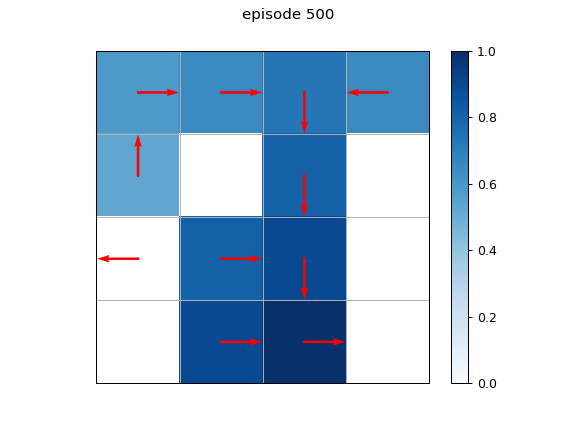

In [12]:
policy.seed(seed)
agent.learn(plot_frequency=50)

Again, the resulting policy follows the shortest path from the starting position to the final goal. In this case, the Q-values for the cells not belonging to this shortest path seem to be even less reliable than in the case of Q-Learning, because Q-values were updated only after finishing an episode. Especially cell 8 has an unreliably low Q-value.

### N-Step Q-Learning 

Without going into the mathematical details, it is useful to mention that the Q-Learning method tends to underfitting sampled data because it is biased, whereas the Monte Carlo method has high variance and therefore tends to overfitting the sampled data. N-step bootstrapping comes to the rescue as it offers a bias-variance tradeoff: if considering the last step only is too biased whereas considering the whole episode leads to overfitting, then the natural middle ground is to consider N steps. This is exactly what N-Step Q-Learning does: at cost of an extra hyperparameter N, it allows to balance between Q-Learning and Monte Carlo. For small problems such as Frozen Lake, the bias-variance tradeoff problem is not really an issue, but for complex problems, it can boost the agent's learning significantly as too much bias or variance can slow down the learning process in these cases. 

So when creating an "NStepQLearning" object, the extra hyperparameter "Nstep" is a required as input argument:

In [13]:
policy = UniformRandomPolicy(env)

strategy = NStepQLearning(num_of_episodes=num_of_episodes,
                          policy=policy, 
                          learning_rate=learning_rate,
                          Nstep=5,  # required input argument
                          gamma=gamma,
                          decay_rate=decay_rate,
                          epsilon_min=epsilon_min,
                          epsilon_max=epsilon_max)

agent = Agent(env, strategy)

<IPython.core.display.Javascript object>


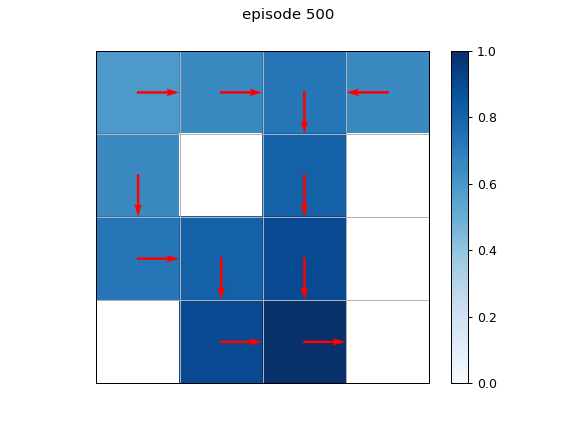

In [14]:
policy.seed(seed)
agent.learn(plot_frequency=50)

As was the case for Q-Learning and Monte Carlo, the resulting policy follows the shortest path from the starting position to the final goal. But in this case, the Q-values for the cells not belonging to this shortest path seem to be more reliable, and consequently, the policy points in the direction of the shortest path in each cell.

### Value Iteration 

The final learning algorithm that is illustrated here is mathematically different from the three previous methods as it uses the empirical MDP to update the state-value function V after each step. However, the code that has to be written to let the agent apply this learning strategy is very similar. Concerning the hyperparameters, Value Iteration has no learning rate. Instead it requires a criterion of convergence as it applies an iterative procedure to update the V-values. This criterion is the required precision. To prevent endless looping when this precision cannot be met, a maximum number of iterations can be set. But to be sure the required precision is always obtained, it can be set to infinity. In the same way, the precision can be set to a negative number to assure each step loops through a fixed number of iterations equal to "maxiter".

In [15]:
policy = UniformRandomPolicy(env)

strategy = ValueIteration(num_of_episodes=num_of_episodes,
                          policy=policy,
                          precision=1e-3,  # optional, default value is 1e-3
                          maxiter=np.Inf,  # optional, default value is 1000
                          gamma=gamma,
                          decay_rate=decay_rate,
                          epsilon_min=epsilon_min,
                          epsilon_max=epsilon_max)

agent = Agent(env, strategy)

<IPython.core.display.Javascript object>


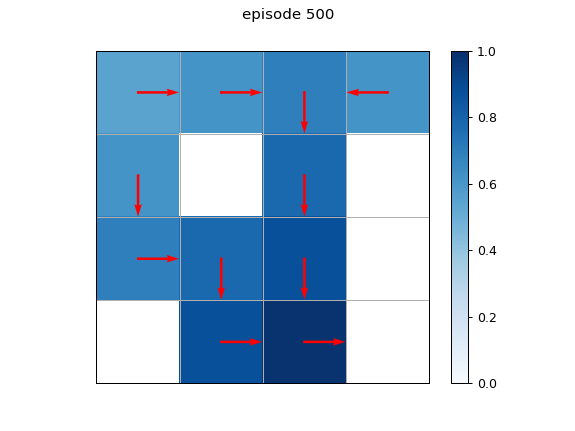

In [16]:
policy.seed(seed)
agent.learn(plot_frequency=50)

Value Iteration gives the same optimal policy as N-Step Q-Learning with N = 5: for each cell, it shows the shortest path to the final goal.

## Stochastic case 

In this section, the four learning strategies are applied to the slippery Frozen Lake environment:

In [17]:
env = FrozenLake.make(is_slippery=True)

The hyperparameters common to all four methods:

In [18]:
num_of_episodes = 1000  # number of episodes, required input argument
decay_rate = 0.005  # decay rate defining the epsilon-greedy policy, required input argument
epsilon_min = 0.01  # minimum value for epsilon, optional argument, default value is 0.01
epsilon_max = 1.0  # maximum value for epsilon, optional argument, default value is 1.0
gamma = 0.9  # discount factor, optional argument, default value is 1.0

Both policy and environment are stochastich in this case and their random processes will use the same seed:

In [19]:
seed = 2020  # random seed for policy and environment

### Exact solution

The solution using Frozen Lake's exact MDP and applying the Value Iteration algorithm for planning:

<IPython.core.display.Javascript object>


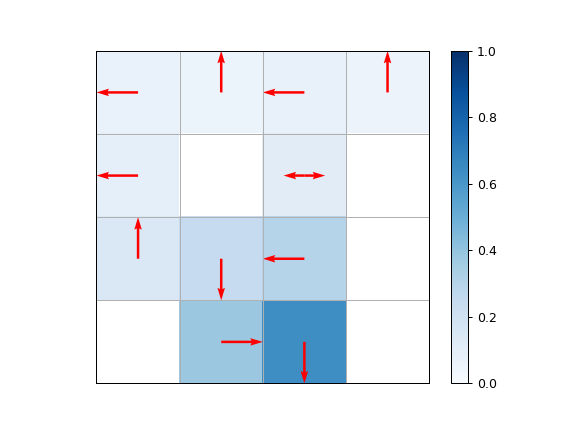

In [20]:
mdp = GymMDP(env, gamma=gamma)
policy_opt, v_opt, q_opt = mdp.value_iteration(outer=5000)
env.plot(values=v_opt, policy=policy_opt)

### Q-Learning 

Because the environment is stochastich, the learning rate should be smaller than 1.0:

In [21]:
learning_rate = 0.2

Creating objects for the initial uniform random policy, the Q-Learning strategy and the agent: 

In [22]:
policy = UniformRandomPolicy(env)

strategy = QLearning(num_of_episodes=num_of_episodes,
                     policy=policy, 
                     learning_rate=learning_rate, 
                     gamma=gamma,
                     decay_rate=decay_rate,
                     epsilon_min=epsilon_min,
                     epsilon_max=epsilon_max)

agent = Agent(env, strategy)

Before calling the agent's "learn" method, not only the policy needs to have its random seed set, but also the environment, as in this case both are stochastic:

<IPython.core.display.Javascript object>


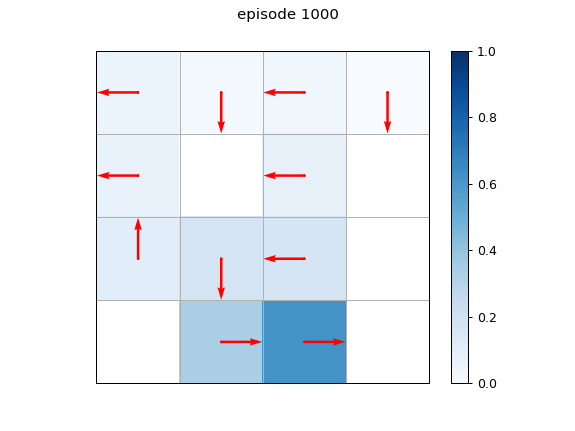

In [23]:
env.seed(seed)
policy.seed(seed)
agent.learn(plot_frequency=50)

The resulting policy doesn't correspond completely to the exact optimal policy calculated using the known MDP. Cells 1 and 3 are not correct, and even will let the agent fall into a hole in one of the three visits. Cell 14 is not correct either. Checking the frequencies, the less reliable Q-values for these cells could be explained by the less frequent visits of the agent:

In [31]:
for state in [ 0,  1,  2,  3, 
               4,      6,
               8,  9, 10,
                  13, 14,    ]:
    print(str(state) + " has " + str(np.sum(strategy.mdp.Nsa[state, :])) + " visits")

0: 5202
1: 1344
2: 1034
3: 913
4: 3469
6: 541
8: 2280
9: 1229
10: 638
13: 842
14: 732


### Monte Carlo 

The Monte Carlo method has no specific hyperparameters:

In [25]:
policy = UniformRandomPolicy(env)

strategy = MonteCarlo(num_of_episodes=num_of_episodes,
                      policy=policy, 
                      learning_rate=learning_rate, 
                      gamma=gamma,
                      decay_rate=decay_rate,
                      epsilon_min=epsilon_min,
                      epsilon_max=epsilon_max)

agent = Agent(env, strategy)

<IPython.core.display.Javascript object>


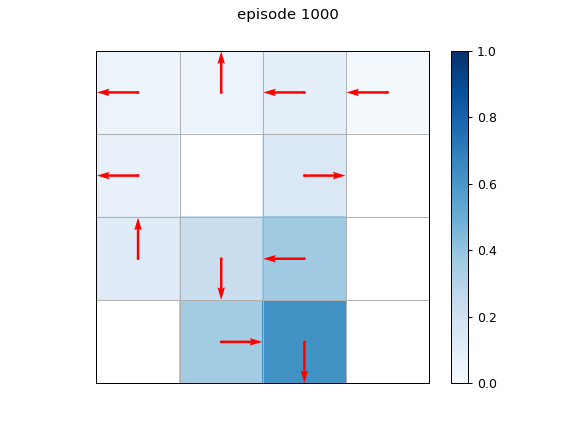

In [26]:
env.seed(seed)
policy.seed(seed)
agent.learn(plot_frequency=50)

The policy found by the Monte Carlo method is very close to the optimal policy. Only cell 3 shows another optimal action to select.

### N-Step Q-Learning 

N-Step Q-Learning requires an extra hyperparameter N:

In [42]:
policy = UniformRandomPolicy(env)

strategy = NStepQLearning(num_of_episodes=num_of_episodes,
                          policy=policy, 
                          learning_rate=learning_rate, 
                          Nstep=5,  # required input argument
                          gamma=gamma,
                          decay_rate=decay_rate,
                          epsilon_min=epsilon_min,
                          epsilon_max=epsilon_max)

agent = Agent(env, strategy)

<IPython.core.display.Javascript object>


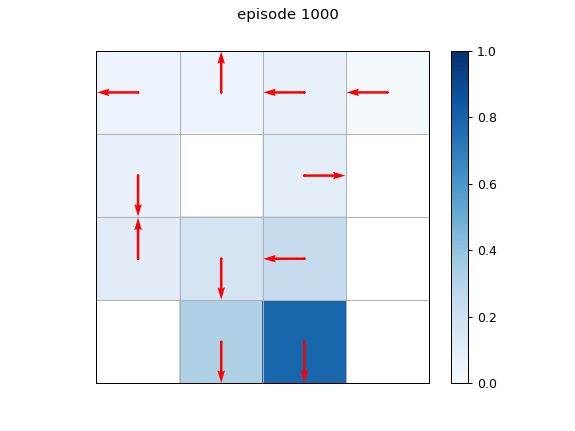

In [43]:
env.seed(seed)
policy.seed(seed)
agent.learn(plot_frequency=50)

N-Step Q-Learning with a step size of 5 gives less accurate results than the Monte Carlo method as its calculated policy deviates from the exact optimal policy in cells 3, 4 and 13.

### Value Iteration

Recall that the Value Iteration algorithm doesn't have a learning rate, but that is requires a stop criterion and a maximum number of iterations:

In [29]:
policy = UniformRandomPolicy(env)

strategy = ValueIteration(num_of_episodes=num_of_episodes,
                          policy=policy,
                          precision=1e-5,  # optional, default value is 1e-3
                          maxiter=5000,  # optional, default value is 1000
                          gamma=gamma,
                          decay_rate=decay_rate,
                          epsilon_min=epsilon_min,
                          epsilon_max=epsilon_max)

agent = Agent(env, strategy)

<IPython.core.display.Javascript object>


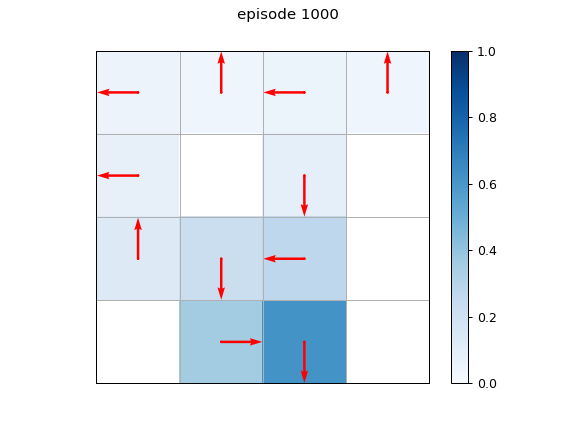

In [30]:
env.seed(seed)
policy.seed(seed)
agent.learn(plot_frequency=50)

This method finds the optimal policy, expcept for cell 6. For this example, it performs as well as the Monte Carlo method, but it is computationally less efficient.

## Conclusion 

In this notebook four reinforcement learning algorithms were illustrated: Q-Learning, Monte Carlo, N-Step Q-Learning, and Value Iteration. Each method was applied to solve the deterministic and stochastic Frozen Lake MDP. The policy simulated by each method was verified against the optimal policy calculated using the exact MDP. Although these algorithms were not fine-tuned yet by optimizing the hyperparameters, the results are close to the exact solution. 